In [1]:
import sys
sys.path.insert(0, "C:/Users/samuel.borms/Desktop/code/cobra")
%load_ext autoreload
%autoreload 2

# Cobra's approach to logistic regression

Cobra requires the usual Python packages for data science, such as numpy, pandas and scikit-learn. These packages, along with their versions are listed in requirements.txt and can be installed using pip.

In [2]:
# pip install -r requirements.txt

If you want to install Cobra with e.g. pip, you don't have to install all of these requirements as these are automatically installed with Cobra itself. Hence, the easiest way to install Cobra is using pip:

In [3]:
# pip install -U pythonpredictions-cobra

*****

This section we will walk you through all the required steps to build a predictive logistic regression model using **Cobra**. All classes and functions used here are well-documented. In case you want more information on a class or function, run `help(function_or_class_you_want_info_from)`.

Building a good model involves three steps:

1. **Preprocessing**: properly prepare the predictors (a synonym for “feature” or variable that we use throughout this tutorial) for modelling.

2. **Feature selection**: automatically select a subset of predictors which contribute most to the target variable or output in which you are interested.

3. **Model evaluation**: once a model has been build, a detailed evaluation can be performed by computing all sorts of evaluation metrics.

Let's dive in!
***

## Survival prediction using Titanic data

- BASETABLE: seaborn dataset Titanic.
- GOAL: Predict if individual survives in Titanic sinking.

Import the necessary libraries first.

In [4]:
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.api.types import is_datetime64_any_dtype

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

In [ ]:
import cobra
cobra.__version__

In [5]:
## specific function imports
from cobra.preprocessing import PreProcessor

from cobra.model_building import univariate_selection
from cobra.model_building import ForwardFeatureSelection
# from cobra.model_building import LogisticRegressionModel

from cobra.evaluation import ClassificationEvaluator
from cobra.evaluation import generate_pig_tables
from cobra.evaluation import plot_univariate_predictor_quality
from cobra.evaluation import plot_correlation_matrix
from cobra.evaluation import plot_performance_curves
from cobra.evaluation import plot_variable_importance
from cobra.evaluation import plot_incidence

In [6]:
df = sns.load_dataset("titanic")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In the example below, we assume the data for model building is available in a pandas DataFrame. This DataFrame should contain a an ID column, a target column (e.g. “**survived**”) and a number of candidate predictors (features) to build a model with.

***


In [7]:
df.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object

It is required to set all category vars to object dtype.

In [8]:
df.loc[:, df.dtypes=="category"] = (df.select_dtypes(["category"]).apply(lambda x: x.astype("object")))

## Data preprocessing

#### The first part focusses on preparing the predictors for modelling by:

1. Defining the ID column, the target, discrete and contineous variables

2. Splitting the dataset into training, selection and validation datasets.

3. Binning continuous variables into discrete intervals

4. Replacing missing values of both categorical and continuous variables (which are now binned) with an additional “Missing” bin/category

5. Regrouping categories in new category “other”

6. Replacing bins/categories with their corresponding incidence rate per category/bin.

*Note to user*: as any good data scientist knows, you still need to deal in your data with irregularities, such as outliers or very skewed distributions.

In this toy dataset, the index will serve as ID.

In [9]:
df["id"] = df.index + 1
id_col = "id"

The target is the "survived" column.

In [10]:
target_col = "survived"

Now, we remove the columns "who" and "adult_male" since they are duplicate of "sex", and also "alive", which seems to be a duplicate of "survived".

In [11]:
df.drop(["who", "adult_male", "alive"], axis=1, inplace=True)

Finding out which variables are categorical (discrete) and which are continuous.

Discrete variables are definitely those that contain strings.

In [12]:
col_dtypes = df.dtypes
discrete_vars = [col for col in col_dtypes[col_dtypes==object].index.tolist() if col not in [id_col, target_col]] 
print(discrete_vars)

['sex', 'embarked', 'class', 'deck', 'embark_town']


Next, we also check for numerical columns that only contain a few different values, thus to be interpreted as discrete, categorical variables


In [13]:
for col in df.columns:
    if col not in discrete_vars and col not in [id_col, target_col]: # omit discrete because a string and target
        val_counts = df[col].nunique()
        if val_counts > 1 and val_counts <= 10: # the column contains less than 10 different values
            print(col)

pclass
sibsp
parch
alone


By taking a look at the printed variables, it is clear that we have to include those in the list of discrete variables.

In [14]:
discrete_vars.extend(["pclass", "sibsp", "parch", "class", "deck", "alone"])
discrete_vars

['sex',
 'embarked',
 'class',
 'deck',
 'embark_town',
 'pclass',
 'sibsp',
 'parch',
 'class',
 'deck',
 'alone']

The remaining variables can be labelled continous predictors, without including the target variable.


In [15]:
continuous_vars = list(set(df.columns)
                       - set(discrete_vars) 
                       - set([id_col, target_col]))
continuous_vars                   

['age', 'fare']

Now, we can prepare **Cobra's PreProcessor** object.

In [16]:
# using all Cobra's default parameters for preprocessing for now:
preprocessor = PreProcessor.from_params(
    model_type="classification"
)

# These are all available options: help(PreProcessor.from_params)

The target encoder's additive smoothing weight is set to 0. This disables smoothing and may make the encoding prone to overfitting. Increase the weight if needed.


Split data into train-selection-validation sets.

In [17]:
basetable = preprocessor.train_selection_validation_split(data=df,
                                                          train_prop=0.6,
                                                          selection_prop=0.2,
                                                          validation_prop=0.2)

Fit the preprocessor pipeline.

In [18]:
preprocessor.fit(basetable[basetable["split"]=="train"],
                 continuous_vars=continuous_vars,
                 discrete_vars=discrete_vars,
                 target_column_name=target_col)

Computing discretization bins...:   0%|          | 0/2 [00:00<?, ?it/s]

Discretizing columns...:   0%|          | 0/2 [00:00<?, ?it/s]

Fitting category regrouping...:   0%|          | 0/11 [00:00<?, ?it/s]

Fitting target encoding...:   0%|          | 0/13 [00:00<?, ?it/s]

This pipeline can now be performed on the basetable!

In [19]:
basetable = preprocessor.transform(basetable,
                                   continuous_vars=continuous_vars,
                                   discrete_vars=discrete_vars)
basetable.head()

Discretizing columns...:   0%|          | 0/2 [00:00<?, ?it/s]

Applying target encoding...:   0%|          | 0/13 [00:00<?, ?it/s]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone,id,split,age_bin,fare_bin,sex_processed,embarked_processed,class_processed,deck_processed,embark_town_processed,pclass_processed,sibsp_processed,parch_processed,alone_processed,sex_enc,embarked_enc,class_enc,deck_enc,embark_town_enc,pclass_enc,sibsp_enc,parch_enc,alone_enc,age_enc,fare_enc
0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,False,1,selection,19.0 - 22.0,0.0 - 7.7,male,Other,Third,Missing,Other,3,1,0,False,0.213068,0.34023,0.235690,0.292162,0.34023,0.235690,0.539062,0.350617,0.513761,0.297297,0.192308
1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,False,2,train,36.0 - 41.0,39.0 - 73.5,female,C,First,Other,Cherbourg,1,1,0,False,0.715847,0.58000,0.658537,0.618182,0.58000,0.658537,0.539062,0.350617,0.513761,0.393939,0.545455
2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,True,3,train,25.0 - 28.0,7.9 - 8.1,female,Other,Third,Missing,Other,3,0,0,True,0.715847,0.34023,0.235690,0.292162,0.34023,0.235690,0.348189,0.350617,0.296530,0.411765,0.230769
3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,False,4,validation,32.0 - 36.0,39.0 - 73.5,female,Other,First,Other,Other,1,1,0,False,0.715847,0.34023,0.658537,0.618182,0.34023,0.658537,0.539062,0.350617,0.513761,0.475000,0.545455
4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,True,5,train,32.0 - 36.0,7.9 - 8.1,male,Other,Third,Missing,Other,3,0,0,True,0.213068,0.34023,0.235690,0.292162,0.34023,0.235690,0.348189,0.350617,0.296530,0.475000,0.230769


## Predictor Insights Graphs

Next, we can the create the so-called Predictor Insights Graphs (PIGs in short). These are graphs that represents the insights of the relationship between a single predictor and the target. More specifically, the predictor is binned into groups, and we represent group size in bars and group (target) incidence in a colored line. Moreover, we have the option to force order of predictor values. First, we compute the output needed to plot the PIG.

In [20]:
predictor_list = [col for col in basetable.columns
                  if col.endswith("_bin") or col.endswith("_processed")]
pig_tables = generate_pig_tables(basetable[basetable["split"]=="selection"],
                                 id_column_name=id_col,
                                 target_column_name=target_col,
                                 preprocessed_predictors=predictor_list)
pig_tables

,variable,label,pop_size,global_avg_target,avg_target
0,age,0.0 - 12.0,0.067416,0.348315,0.583333
1,age,12.0 - 19.0,0.123596,0.348315,0.409091
2,age,19.0 - 22.0,0.084270,0.348315,0.000000
3,age,22.0 - 25.0,0.067416,0.348315,0.500000
4,age,25.0 - 28.0,0.073034,0.348315,0.230769
...,...,...,...,...,...
2,sibsp,2,0.022472,0.348315,0.250000
3,sibsp,3,0.028090,0.348315,0.400000
4,sibsp,4,0.011236,0.348315,0.000000
5,sibsp,5,0.011236,0.348315,0.000000


Then, we can plot a PIG graph for each of the predictors in the basetable. For instance, for the variable age.

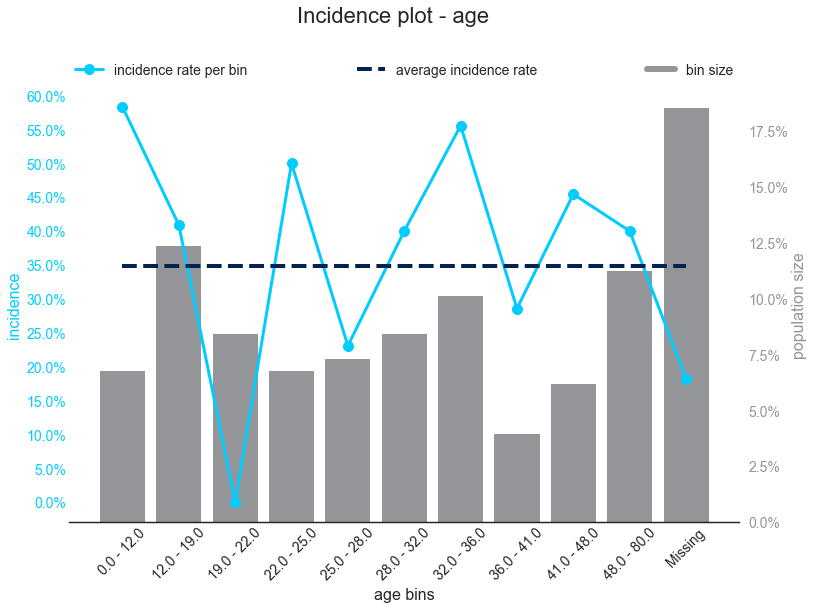

In [21]:
col_order = list(basetable["age_bin"].unique().sort_values())
plot_incidence(pig_tables, variable="age", model_type="classification", column_order=col_order)

## Feature selection

Once the predictors are properly prepared, we can start building a predictive model, which boils down to selecting the right predictors from the dataset to train a model on.

As a dataset typically contains many predictors, **we first perform a univariate preselection** to rule out any predictor with little to no predictive power. 

Later, using the list of preselected features, we build a logistic regression model using **forward feature selection** to choose the right set of predictors.

In previous steps, these were the predictors, as preprocessed so far:

In [22]:
preprocessed_predictors = [
    col for col in basetable.columns
    if col.endswith("_bin") or col.endswith("_processed")]
sorted(preprocessed_predictors)

['age_bin',
 'alone_processed',
 'class_processed',
 'deck_processed',
 'embark_town_processed',
 'embarked_processed',
 'fare_bin',
 'parch_processed',
 'pclass_processed',
 'sex_processed',
 'sibsp_processed']

But for feature selection, we use the target encoded version of each of these.

In [23]:
preprocessed_predictors = [col for col in basetable.columns.tolist() if "_enc" in col]

A univariate selection on the preprocessed predictors can be conducted. The thresholds for retaining a feature are now on default but can be changed by the user.


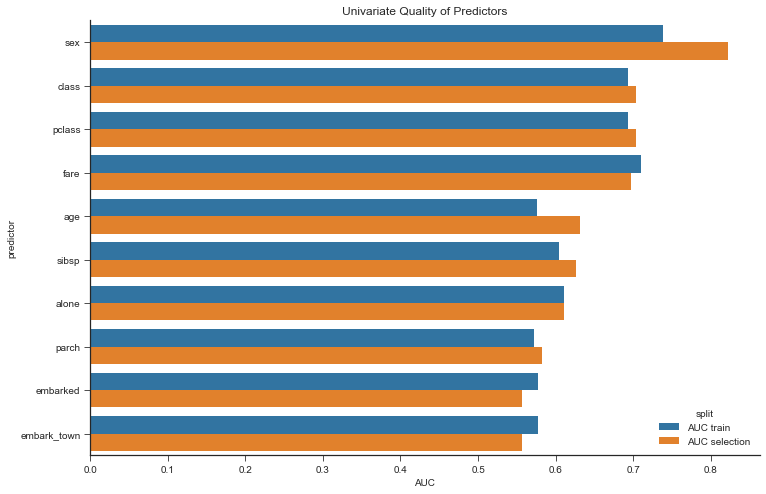

In [24]:
df_auc = univariate_selection.compute_univariate_preselection(
    target_enc_train_data=basetable[basetable["split"]=="train"],
    target_enc_selection_data=basetable[basetable["split"]=="selection"],
    predictors=preprocessed_predictors,
    target_column=target_col,
    preselect_auc_threshold=0.53,  # if auc_selection <= 0.53 exclude predictor
    preselect_overtrain_threshold=0.05)  # if (auc_train - auc_selection) >= 0.05 --> overfitting!

plot_univariate_predictor_quality(df_auc)

Next, we compute correlations between the preprocessed predictors and plot it using a correlation matrix.

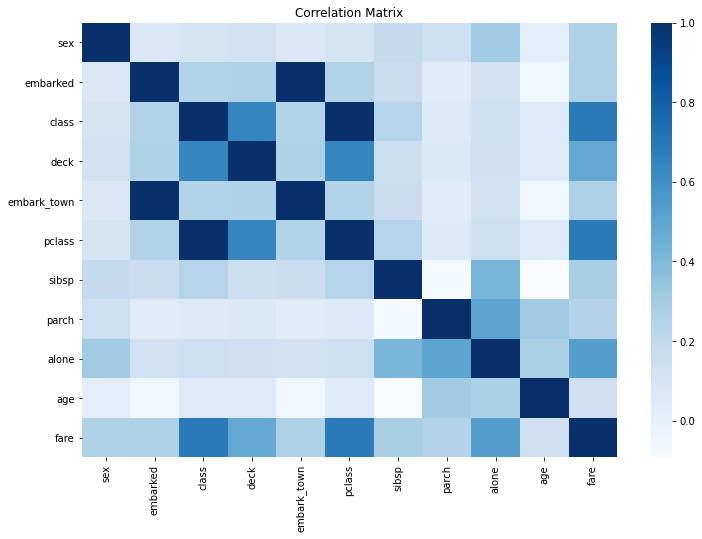

In [25]:
df_corr = (univariate_selection
           .compute_correlations(basetable[basetable["split"]=="train"],
                                 preprocessed_predictors))
plot_correlation_matrix(df_corr)

To get a list of the selected predictors after the univariate selection, run the following call:


In [26]:
preselected_predictors = univariate_selection.get_preselected_predictors(df_auc)
preselected_predictors

['sex_enc',
 'class_enc',
 'pclass_enc',
 'fare_enc',
 'age_enc',
 'sibsp_enc',
 'alone_enc',
 'parch_enc',
 'embarked_enc',
 'embark_town_enc']

After an initial preselection on the predictors, we can start building the model itself using forward feature selection to choose the right set of predictors. Since we use target encoding on all our predictors, we will only consider models with positive coefficients (no sign flip should occur) as this makes the model more interpretable.

## Modeling

In [27]:
forward_selection = ForwardFeatureSelection(model_type="classification",
                                            max_predictors=30,
                                            pos_only=True)

# fit the forward feature selection on the train data
# has optional parameters to force and/or exclude certain predictors (see docs)
forward_selection.fit(basetable[basetable["split"]=="train"],
                      target_column_name=target_col,
                      predictors=preselected_predictors)

# compute model performance
performances = (forward_selection
                .compute_model_performances(basetable, target_column_name=target_col))
performances

Sequentially adding best predictor...:   0%|          | 0/10 [00:00<?, ?it/s]

,predictors,last_added_predictor,train_performance,selection_performance,validation_performance,model_type
0,[sex_enc],sex_enc,0.738934,0.821885,0.800416,classification
1,"[sex_enc, class_enc]",class_enc,0.817718,0.878615,0.837188,classification
2,"[class_enc, sex_enc, age_enc]",age_enc,0.834236,0.884594,0.842840,classification
3,"[class_enc, sex_enc, age_enc, embarked_enc]",embarked_enc,0.840116,0.883343,0.844790,classification
4,"[class_enc, embarked_enc, sex_enc, age_enc, pa...",parch_enc,0.841274,0.882856,0.843425,classification
5,"[parch_enc, class_enc, embarked_enc, sex_enc, ...",sibsp_enc,0.843148,0.890990,0.849402,classification
6,"[parch_enc, sibsp_enc, class_enc, embarked_enc...",fare_enc,0.843590,0.890712,0.848688,classification
7,"[parch_enc, sibsp_enc, fare_enc, class_enc, em...",pclass_enc,0.843694,0.890712,0.848688,classification
8,"[parch_enc, fare_enc, sibsp_enc, class_enc, pc...",embark_town_enc,0.843694,0.890712,0.848688,classification


As can be seen, we have completed 6 steps till no further improvement can be observed

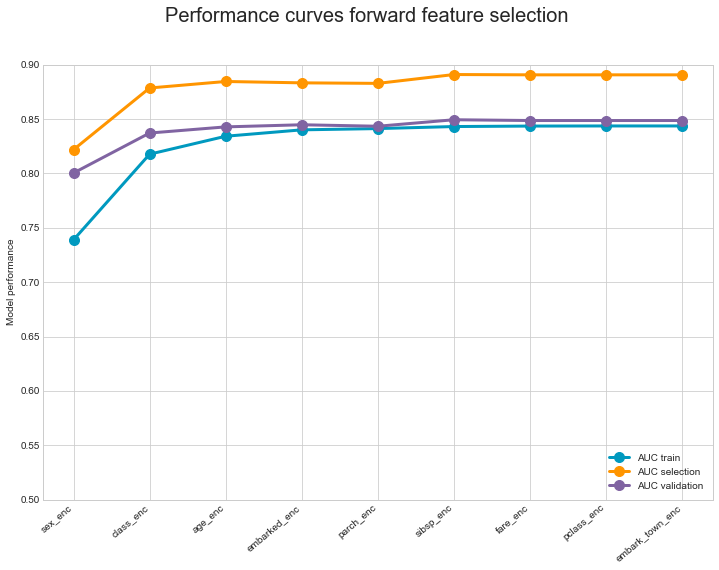

In [28]:
# plot performance curves
plot_performance_curves(performances)

Based on the performance curves (AUC per model with a particular number of predictors in case of logistic regression), a final model can then be chosen and the variables importance can be plotted:


In [29]:
# pick the optimal step based on visual inspection in the plot above (try to find a knee point)
model = forward_selection.get_model_from_step(5)

final_predictors = model.predictors
final_predictors

['parch_enc', 'class_enc', 'embarked_enc', 'sex_enc', 'age_enc', 'sibsp_enc']

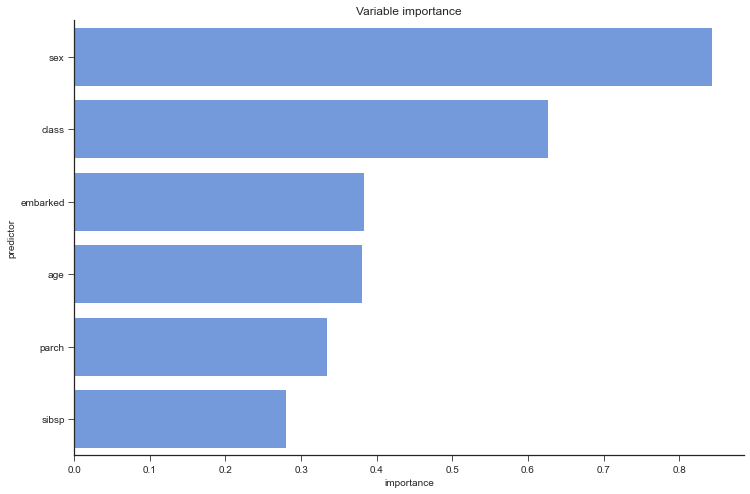

In [30]:
variable_importance = model.compute_variable_importance(
    basetable[basetable["split"]=="selection"]
)
plot_variable_importance(variable_importance)

**Note**: variable importance is based on correlation of the predictor with the model scores (and not the true labels!).

Finally, if wanted, we can convert the model to a dictionary to store it as JSON.

In [31]:
model_dict = model.serialize()
model_dict

{'meta': 'logistic-regression',
 'predictors': ['parch_enc',
  'class_enc',
  'embarked_enc',
  'sex_enc',
  'age_enc',
  'sibsp_enc'],
 '_eval_metrics_by_split': {'train': 0.8431478147962346,
  'selection': 0.8909899888765294,
  'validation': 0.8494022869022869},
 'params': {'C': 1000000000.0,
  'class_weight': None,
  'dual': False,
  'fit_intercept': True,
  'intercept_scaling': 1,
  'l1_ratio': None,
  'max_iter': 100,
  'multi_class': 'auto',
  'n_jobs': None,
  'penalty': 'l2',
  'random_state': 42,
  'solver': 'liblinear',
  'tol': 0.0001,
  'verbose': 0,
  'warm_start': False},
 'classes_': [0, 1],
 'coef_': [[1.8355006899588193,
   4.425089647429058,
   2.6962961751414154,
   4.728968513306399,
   5.021971105587632,
   2.1483972871281782]],
 'intercept_': [-8.671610876045246],
 'n_iter_': [5]}

In [32]:
if False:
    ## To save the model as a JSON file, run the following snippet
    model_path = os.path.join("output", "model.json")
    with open(model_path, "w") as file:
        json.dump(model_dict, file)

    ## To reload the model again from a JSON file, run the following snippet
    with open(model_path, "r") as file:
        model_dict = json.load(file)
    model = LogisticRegressionModel()
    model.deserialize(model_dict)

## Evaluation

Now that we have built and selected a final model, it is time to evaluate its predictions on the test set against various evaluation metrics. The used evaluation metrics are:

1. Accuracy
2. Area Under Curve (AUC)
3. Precision
4. Recall
5. F1
6. Matthews correlation coefficient
7. Lift at given percentage

Furthermore, we can evaluate the classification performance using a confusion matrix.

Plotting makes the evaluation of a logistic regression model a lot easier. We will first use a **Receiver Operating Characteristic (ROC) curve**, which is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis). Next, we display the **Cumulative Gains curve**, **Cumulative Lift curve** and **Cumulative Response curve**.

In [33]:
# get numpy array of True target labels and predicted scores:
y_true = basetable[basetable["split"]=="selection"][target_col].values
y_pred = model.score_model(basetable[basetable["split"]=="selection"])

In [34]:
evaluator = ClassificationEvaluator()
evaluator.fit(y_true, y_pred)  # Automatically find the best cut-off probability

In [35]:
evaluator.scalar_metrics

accuracy             0.814607
AUC                  0.890990
precision            0.710145
recall               0.790323
F1                   0.748092
matthews_corrcoef    0.604243
lift at 0.05         2.510000
dtype: float64

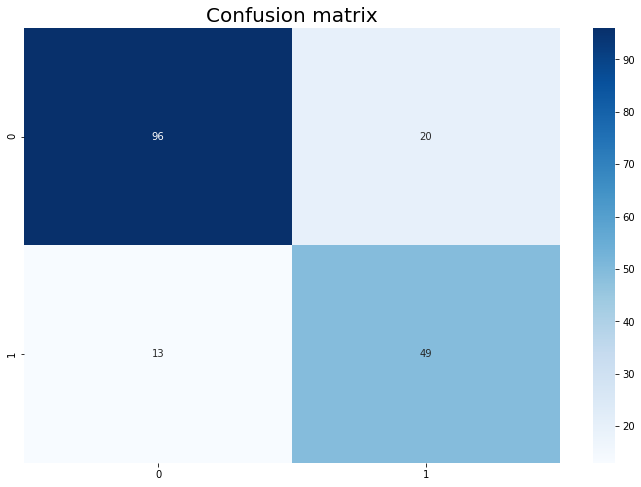

In [36]:
evaluator.plot_confusion_matrix()

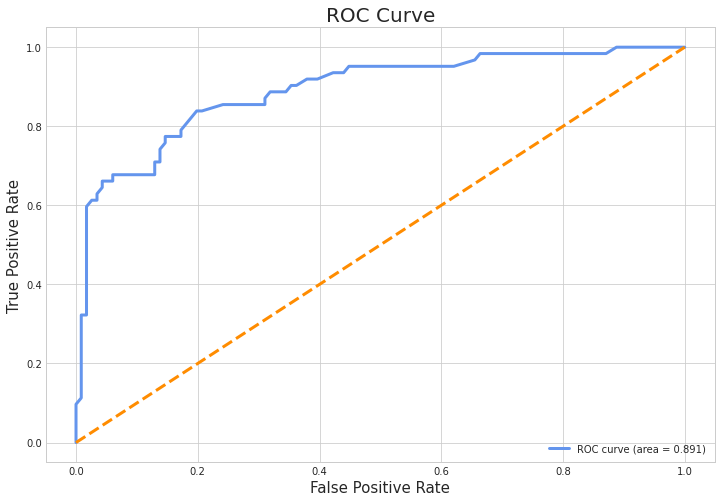

In [37]:
evaluator.plot_roc_curve()

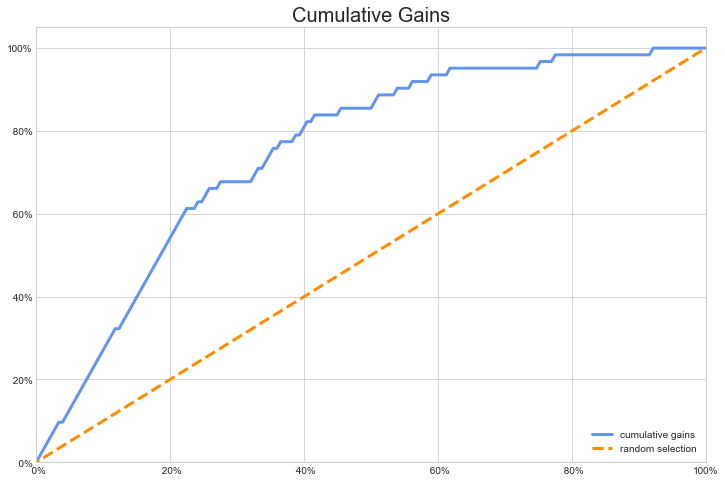

In [38]:
evaluator.plot_cumulative_gains()

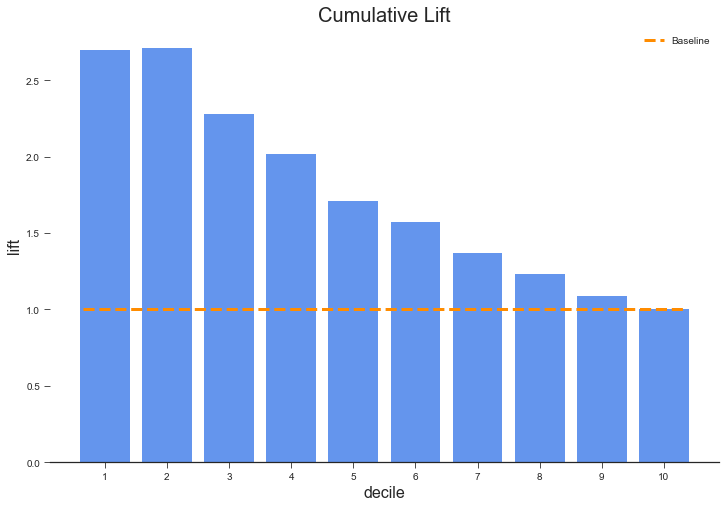

In [39]:
evaluator.plot_lift_curve()

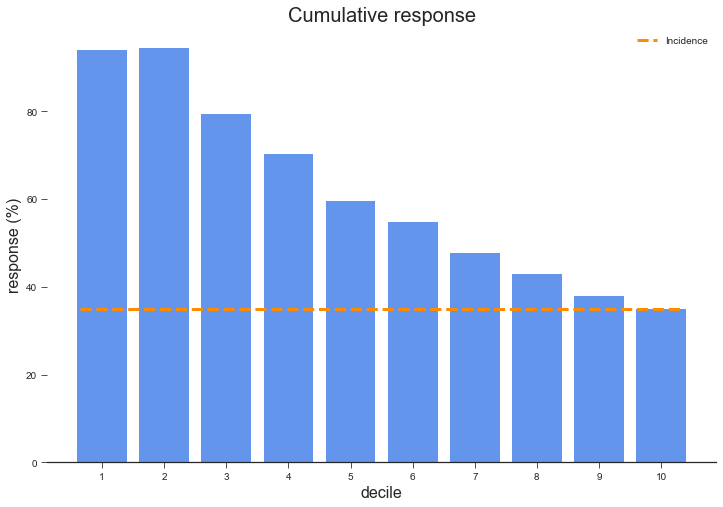

In [40]:
evaluator.plot_cumulative_response_curve()